## Fitting the crystal field parameters of Yb$_2$Ti$_2$O$_7$

Yb$_2$Ti$_2$O$_7$ is famous as a “quantum spin ice” material – the “quantum” part comes from the fact that at low temperatures it behaves as an effective S=$\frac{1}{2}$ system with strong anisotropy which is needed to stabilise a quantum spin liquid. This is because although the magnetic Yb$^{3+}$ ions actually have a full moment of J=$\frac{7}{2}$, the crystal field splits this into 4 doublets and the splitting is such that the ground state doublet has a large energy gap to the first excited state. 

We will be looking at fitting the crystal field parameters of Yb$_2$Ti$_2$O$_7$ in today’s practical.

First we load the data using MSlice


(0.0, 100.0)

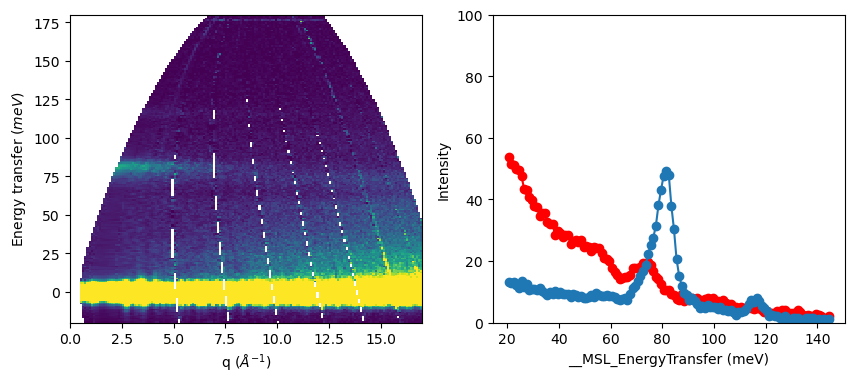

In [28]:
import mantid.simpleapi
import mslice.cli as mc
import mslice.plotting.pyplot as mplt
import matplotlib.pyplot as plt
import numpy as np

import os
data_folder = os.path.join(os.getcwd(), '..', 'datafiles')
# You may need to rename this to some actual directory where the data are.
# The above code assumes you downloaded the zip of the course materials and did not change the path of this notebook.
#data_folder = r'c:\some\path\to\the\datafiles'

# Loads the data and make a 2D slice and two cuts (at low and high Q)
ws_yb2ti2o7_Ei200_100K = mc.Load(Filename=f'{data_folder}/yb2ti2o7_Ei200_100K.nxspe', 
                                 OutputWorkspace='yb2ti2o7_Ei200_100K')
slice_ws = mc.Slice(ws_yb2ti2o7_Ei200_100K, Axis1="|Q|, 0, 17, 0.1", Axis2="DeltaE,-20, 180, 1", NormToOne=False)
cut_lowq = mc.Cut(ws_yb2ti2o7_Ei200_100K, CutAxis="DeltaE,20, 145, 1", IntegrationAxis="|Q|,0,5,0.0")
cut_highq = mc.Cut(ws_yb2ti2o7_Ei200_100K, CutAxis="DeltaE,20, 145, 1", IntegrationAxis="|Q|,12,17,0.0")

fig, ax = plt.subplots(1, 2, subplot_kw={'projection':'mantid'}, figsize=(10, 4))
ax[0].pcolormesh(mc.Transpose(slice_ws).raw_ws, cmap='viridis', vmin=0, vmax=100)
ax[1].errorbar(cut_highq.raw_ws, color="r", marker="o", ls="-", lw=1.5)
ax[1].errorbar(cut_lowq.raw_ws, color="#1f77b4", marker="o", ls="-", lw=1.5)
ax[1].set_ylim((0, 100))

We made two cuts at high and low Q, and will use this for background subtraction. Because the CEF excitations are magnetic, the have negligible intensity at high Q (above around 7	Å$^{-1}$).

We now need to find a scaling factor between the two cuts, so we can subtract them.

We can do this by plotting the Q dependence of the phonon modes between 10 and 50 meV.

<ErrorbarContainer object of 3 artists>

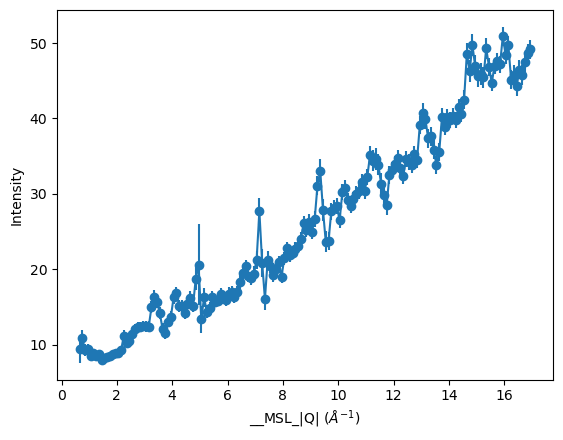

In [29]:
cut_q = mc.Cut(ws_yb2ti2o7_Ei200_100K, CutAxis="|Q|, 0, 17, 0.1", IntegrationAxis="DeltaE, 10, 50, 0.0")
ax = plt.subplot(111, projection='mantid')
ax.errorbar(cut_q.raw_ws, color="#1f77b4", marker="o", ls="-", lw=1.5)

We can either fit this cut with a Q$^2$ expression and find the coefficient or we can eyeball a scale factor - the low Q cut is centred around 2.5Å$^{-1}$ whilst the high Q cut is around 14.5Å$^{-1}$.

This gives an intensity ratio of approximately 11 / 42 = `0.26`

(0.0, 60.0)

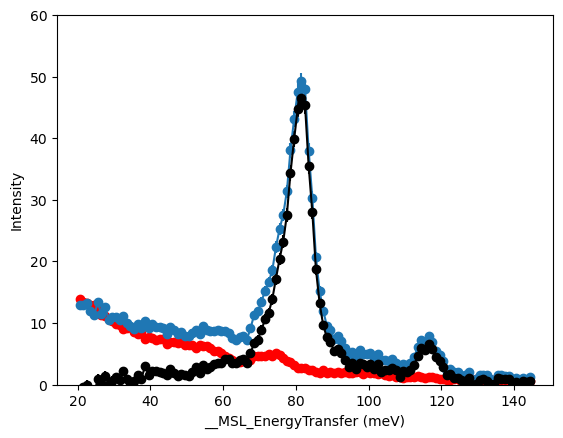

In [30]:
sub_cut = cut_lowq - 0.26 * cut_highq

ax = plt.subplot(111, projection='mantid')
ax.errorbar(0.26*cut_highq.raw_ws, color="r", marker="o", ls="-", lw=1.5)
ax.errorbar(cut_lowq.raw_ws, color="#1f77b4", marker="o", ls="-", lw=1.5)
ax.errorbar(sub_cut.raw_ws, color="k", marker="o", ls="-", lw=1.5)
ax.set_ylim((0, 60))

We now run a fit by first setting up a resolution model for the measurement parameters, generating some random starting parameters and running a fit.

We then plot the fitted spectra and some calculated physical properties measurement, which can be compared to this data:

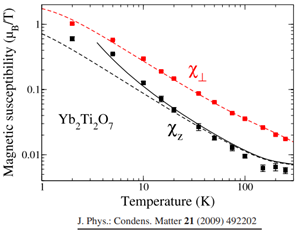

You might have to run this a couple of times to get a good fit.

In [ ]:
from CrystalField import CrystalField, CrystalFieldFit, ResolutionModel
from pychop.Instruments import Instrument
from mantid.simpleapi import mtd, CreateWorkspace, DeleteWorkspace
from mantid.api import AnalysisDataService

cf_cut = AnalysisDataService.Instance().addOrReplace('cf_cut', sub_cut.convert_to_matrix().raw_ws)

# Set up a resolution model for MARI
mari = Instrument('MARI', 'S', 300)
mari.setEi(200)
resmod = ResolutionModel(mari.getResolution, xstart=-200, xend=199)

# Generates a random set of parameters
nonzero_parameters = ['B20', 'B40', 'B60', 'B43', 'B63', 'B66']
Blm = {}
for pname in nonzero_parameters:
    Blm[pname] = (np.random.rand()*2-1)/10
cf = CrystalField('Yb', 'D3d', Temperature=100, ResolutionModel=resmod, **Blm)

if 'estimated_parameters' in mtd:
    DeleteWorkspace('estimated_parameters')
# Runs the estimate_parameters algorithm to find a decent set of initial parameters
cffit = CrystalFieldFit(cf, InputWorkspace='cf_cut', Exclude=[-200,20], MaxIterations=0)
cffit.estimate_parameters(EnergySplitting=120, 
                          Parameters=nonzero_parameters, 
                          NSamples=10000, 
                          Seed=int(np.random.rand()*1e5))
print('Returned', cffit.get_number_estimates(), 'sets of parameters.')
cffit.select_estimated_parameters(1)
print('Best guess parameters:')
for pname in nonzero_parameters:
    print('%s = %5.3g' % (pname, cf[pname]))

# Reruns the fit on these parameters
cffit.fit()
Blmfit = {pname:cf[pname] for pname in nonzero_parameters}

# Calculates the resulting crystal field spectrumInfo
cf = CrystalField('Yb', 'D3d', Temperature=100, ResolutionModel=resmod, **Blmfit)

# Actual parameters (from PRB 97 224409 (2018))
#cf = CrystalField('Yb', 'D3d', Temperature=100, ResolutionModel=resmod,
#    B20=1.1, B40=-0.0591, B43=0.3258, B60=0.00109, B63=0.0407, B66=0.00727)

# Define a background function for the CrystalField Model
ws_fit = CreateWorkspace(*cf.getSpectrum())
ws_invchi = CreateWorkspace(*cf.getSusceptibility(Temperature=np.linspace(1,30,300), Unit='cgs', Inverse=True, Hdir='powder'))
ws_chipar = CreateWorkspace(*cf.getSusceptibility(Temperature=np.linspace(1,300,300), Unit='bohr', Inverse=False, Hdir=[0,0,1]))
ws_chiperp = CreateWorkspace(*cf.getSusceptibility(Temperature=np.linspace(1,300,300), Unit='bohr', Inverse=False, Hdir=[1,0,0]))
ws_magx = CreateWorkspace(*cf.getMagneticMoment(Hmag=np.linspace(0,30,300), Unit='bohr', Inverse=False, Hdir=[1,0,0]))
ws_magy = CreateWorkspace(*cf.getMagneticMoment(Hmag=np.linspace(0,30,300), Unit='bohr', Inverse=False, Hdir=[0,1,0]))
ws_magz = CreateWorkspace(*cf.getMagneticMoment(Hmag=np.linspace(0,30,300), Unit='bohr', Inverse=False, Hdir=[0,0,1]))

fig, ax = plt.subplots(1, 2, subplot_kw={'projection':'mantid'}, figsize=(10, 4))
ax[0].plot(ws_fit, '-k', lw=2)
ax[0].errorbar(sub_cut.raw_ws, color="r", marker=".", ls="-", lw=1.5)
ax[0].set_ylim((0,100))
ax[1].plot(ws_chipar)
ax[1].plot(ws_chiperp)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

np.set_printoptions(precision=3, linewidth=150, suppress=True)
print(cf.getEigenvalues())
print(cf.getEigenvectors())